# **Proyecto Final**

## **Creamos la sesion de spark**


_______

In [32]:
# 📌 1️⃣ Eliminar cualquier instalación previa
!rm -rf /content/spark-*
!apt-get update > /dev/null
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# 📌 2️⃣ Descargar Spark 3.5.0 desde Apache (con verificación de descarga)
!curl -o /content/spark-3.5.0-bin-hadoop3.tgz https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

# 📌 3️⃣ Verificar si el archivo se descargó correctamente
!ls -lh /content/spark-3.5.0-bin-hadoop3.tgz

# 📌 4️⃣ Extraer el archivo si es válido
!tar xf /content/spark-3.5.0-bin-hadoop3.tgz -C /content/

# 📌 5️⃣ Configurar variables de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["SPARK_HOME"], "bin")
os.environ["PYTHONPATH"] = os.path.join(os.environ["SPARK_HOME"], "python") + os.pathsep + os.path.join(os.environ["SPARK_HOME"], "python/lib/py4j-0.10.9.7-src.zip")

# 📌 6️⃣ Instalar PySpark
!pip install -q pyspark

# 📌 7️⃣ Iniciar la sesión de Spark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MiSparkApp") \
    .master("local[*]") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print("✅ Spark inicializado correctamente:", spark.version)



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  381M  100  381M    0     0  1460k      0  0:04:27  0:04:27 --:--:-- 1524k
-rw-r--r-- 1 root root 382M Mar  3 11:21 /content/spark-3.5.0-bin-hadoop3.tgz
✅ Spark inicializado correctamente: 3.5.0


________
________

In [33]:
# importamos funciones para trabajo con dataframes
from pyspark.sql import functions as F


## **EDA para csv de empresas**

_____


In [36]:
#Leemos el primer data frame de empresas

df_empresas= spark.read.csv("/content/Empresas_Sostenibilidad.csv", header=True, inferSchema=True)
df_empresas.show()

+----------+----------+-----------+-------+---------------+-------------+----------------------+
|empresa_id|    nombre|     sector|   pais|consumo_energia|emisiones_co2|certificacion_iso14001|
+----------+----------+-----------+-------+---------------+-------------+----------------------+
| EMP000000| Empresa_0|    Energía| Canadá|        44404.7|       3217.3|                     0|
| EMP000001| Empresa_1|   Finanzas|  China|       25576.11|      16135.7|                     1|
| EMP000002| Empresa_2|      Salud|  Japón|       29305.07|      2224.93|                     0|
| EMP000003| Empresa_3| Transporte|  China|       44600.25|      3764.32|                     1|
| EMP000004| Empresa_4| Tecnología|Francia|       46039.63|     11840.17|                     1|
| EMP000005| Empresa_5|Manufactura| Canadá|       41988.85|      5665.54|                     1|
| EMP000006| Empresa_6|    Energía|  China|        2793.22|      3871.34|                     0|
| EMP000007| Empresa_7| Transp

In [37]:
# Mostramos el esquema y el numero de filas
df_empresas.printSchema()
print("Numero de filas: ", df_empresas.count())

root
 |-- empresa_id: string (nullable = true)
 |-- nombre: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- consumo_energia: double (nullable = true)
 |-- emisiones_co2: double (nullable = true)
 |-- certificacion_iso14001: integer (nullable = true)

Numero de filas:  24627


##### Observaciones:

- Tenemos 24627 registros en este dataframe
- Observamos que el tipo de las variables estas correctamente asignado, es decir no se tiene un string en alguna de las variables que debe ser numerica, lo cual nos indica que esas columnas estan correctamente compuestas por valores numericos en todas sus filas.
- Vemos que en la columna de sector y país se tienen valores con tildes, lo cual puede representar un posible inconveniente futuro por lo cual deberiamos homogenizar esto.

In [38]:
# Reviso si hay duplicados agrupando por todos los campos y muestro los registros duplicados
df_empresas.groupBy('empresa_id', 'nombre', 'sector','pais','consumo_energia','emisiones_co2','certificacion_iso14001').count().filter(F.col('count')>1).show()

+----------+------+------+----+---------------+-------------+----------------------+-----+
|empresa_id|nombre|sector|pais|consumo_energia|emisiones_co2|certificacion_iso14001|count|
+----------+------+------+----+---------------+-------------+----------------------+-----+
+----------+------+------+----+---------------+-------------+----------------------+-----+



##### Obervaciones:

- Agrupamos por todos los campos y usamos una función de agregación en este caso count, que nos dara la cantidad de veces que un registro se repite en el dataframe. Filtramos los que se repitan mas de una vez y vemos que el DataFrame esta vacío.

- Al no tener registros duplicados, mantenemos todo igual y procedemos a seguir limpiando los datos con posteriores validaciones según corresponda

In [39]:
# verificamos cuantos valores nulos hay en cada columna del Data frame
df_empresas.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_empresas.columns
]).show()

+----------+------+------+----+---------------+-------------+----------------------+
|empresa_id|nombre|sector|pais|consumo_energia|emisiones_co2|certificacion_iso14001|
+----------+------+------+----+---------------+-------------+----------------------+
|         0|     0|     0|   0|              0|            0|                     0|
+----------+------+------+----+---------------+-------------+----------------------+



##### Obervaciones:

- Revisamos la cantidad de valores nulos en cada columna. Vemos que las variables no tienen valores nulos en sus filas, por lo que no eliminamos ni tratamos ningun registro

In [40]:
# En este caso calculamos los principales estadisticos descriptivos para consumo de energia y emisiones co2 ya que son las variables que tienen sentido.
df_stats_empresas= df_empresas.describe(['consumo_energia','emisiones_co2'])
df_stats_empresas.show()

+-------+------------------+-----------------+
|summary|   consumo_energia|    emisiones_co2|
+-------+------------------+-----------------+
|  count|             24627|            24627|
|   mean| 25195.89757177069|10089.50704348889|
| stddev|14262.971248483236|5776.336618176933|
|    min|            500.65|            10.14|
|    max|          49999.47|         19999.44|
+-------+------------------+-----------------+



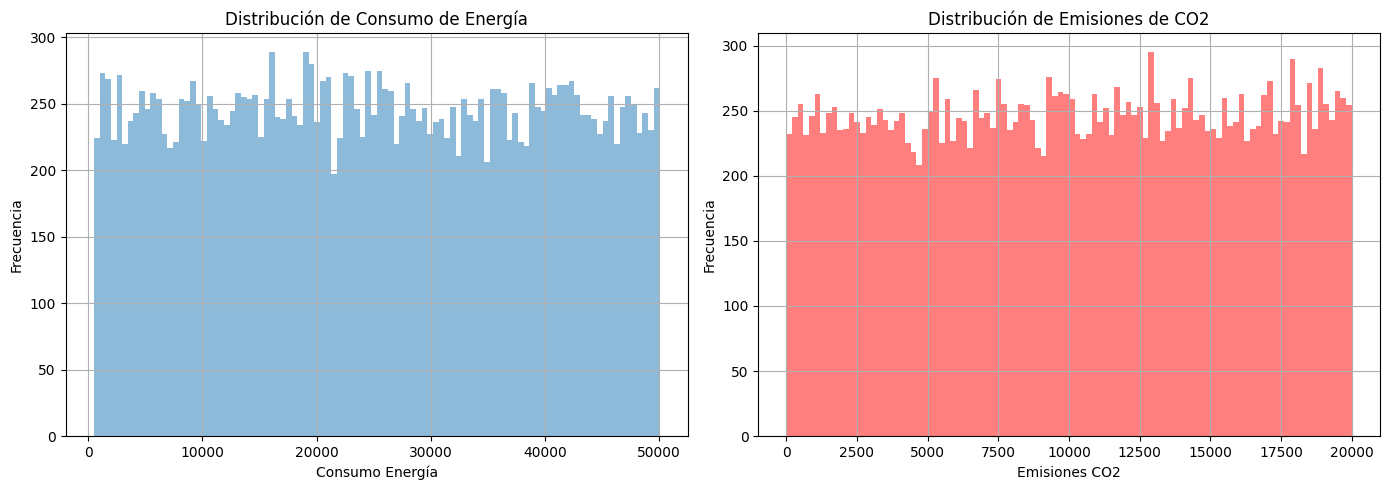

In [41]:
import matplotlib.pyplot as plt

# Convertir los datos de PySpark a Pandas para graficar
df_pandas = df_empresas.select("consumo_energia", "emisiones_co2").toPandas()

# Crear subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Histograma de consumo de energía
axes[0].hist(df_pandas["consumo_energia"], bins=100, alpha=0.5, label="Consumo Energía")
axes[0].set_xlabel("Consumo Energía")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de Consumo de Energía")
axes[0].grid()

# Histograma de emisiones de CO2
axes[1].hist(df_pandas["emisiones_co2"], bins=100, alpha=0.5, label="Emisiones CO2", color='r')
axes[1].set_xlabel("Emisiones CO2")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución de Emisiones de CO2")
axes[1].grid()

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Mostrar gráfico
plt.show()



##### Obervaciones:

- Calculamos los principales estadísticos desctiptivos para la media para las dos variables numericas que tenemos.

- Observamos graficamente que en los 2 casos la distribución de los datos no esta sesgada hacia ningún lado. Se tienen valores en proporciones muy similares a lo largo del rango de cada variable, lo que quiere decir que cada variable numerica en el dataset esta relativamente equilibrada entre magnitudes con valores bajos y altos

In [55]:
# Procedemos a tratar las columnas de sector y país de acuerdo a lo comentado anteriormente. Eliminamos las tildes.

!pip install unidecode
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from unidecode import unidecode

# Creamos una UDF
quitar_tildes_udf = udf(lambda texto: unidecode(texto) if texto else texto, StringType())

# Aplicar la UDF a las columnas con caracteres acentuados
df_empresas_limpio = df_empresas.withColumn("sector_2", quitar_tildes_udf(df_empresas["sector"])).withColumn("pais_2", quitar_tildes_udf(df_empresas["pais"])).drop("sector", "pais")

# Al eliminar anteriormente las columnas sector y pais, renombro las nuevas que agregue sin tildes con el nombre de columna original.
df_empresas_limpio = df_empresas_limpio.withColumnRenamed("sector_2", "sector").withColumnRenamed("pais_2", "pais")

# Mostrar el resultado limpio
df_empresas_limpio.show()


+----------+----------+---------------+-------------+----------------------+-----------+-------+
|empresa_id|    nombre|consumo_energia|emisiones_co2|certificacion_iso14001|     sector|   pais|
+----------+----------+---------------+-------------+----------------------+-----------+-------+
| EMP000000| Empresa_0|        44404.7|       3217.3|                     0|    Energia| Canada|
| EMP000001| Empresa_1|       25576.11|      16135.7|                     1|   Finanzas|  China|
| EMP000002| Empresa_2|       29305.07|      2224.93|                     0|      Salud|  Japon|
| EMP000003| Empresa_3|       44600.25|      3764.32|                     1| Transporte|  China|
| EMP000004| Empresa_4|       46039.63|     11840.17|                     1| Tecnologia|Francia|
| EMP000005| Empresa_5|       41988.85|      5665.54|                     1|Manufactura| Canada|
| EMP000006| Empresa_6|        2793.22|      3871.34|                     0|    Energia|  China|
| EMP000007| Empresa_7|       

In [74]:
# Compruebo que lo hizo bien

df_empresas_limpio.printSchema()
print(df_empresas_limpio.count())

root
 |-- empresa_id: string (nullable = true)
 |-- nombre: string (nullable = true)
 |-- consumo_energia: double (nullable = true)
 |-- emisiones_co2: double (nullable = true)
 |-- certificacion_iso14001: integer (nullable = true)
 |-- sector: string (nullable = true)
 |-- pais: string (nullable = true)

24627


In [67]:
df_empresas_limpio.groupBy('sector').count().show()
df_empresas_limpio.groupBy('pais').count().show()

+------------+-----+
|      sector|count|
+------------+-----+
|       Salud| 3601|
| Manufactura| 3604|
|    Finanzas| 3542|
|Construccion| 3551|
|     Energia| 3443|
|  Transporte| 3453|
|  Tecnologia| 3433|
+------------+-----+

+--------+-----+
|    pais|count|
+--------+-----+
| Francia| 2448|
|   China| 2422|
|   India| 2488|
|Alemania| 2469|
|  Mexico| 2474|
|   Japon| 2508|
|  Espana| 2453|
|    EEUU| 2448|
|  Canada| 2446|
|  Brasil| 2471|
+--------+-----+



#### Obervaciones:

- Corregí los campos de las variables sector y país que contenían tíldes para facilitar posibles cruces futuros, agregaciones, etc, y tener homogenización en los nombres.

- Al agrupar por pais y sector evidencio que no existen incoherencias, no hay un pais que salga duplicado por que en un caso tenga tilde y en otro caso no, mismo caso con sector. Es decir la udf se hizo bien.

In [69]:
# Habiendo realizado la limpieza del primer dataset junto con su EDA, exportamos el data set limpio,
#el cual será la entrada del siguiente proceso para llegar a las tablas de salida deseadas

df_empresas_limpio.write.parquet("/content/empresas_limpio.parquet")

------
------

## **EDA para csv proyectos**

___________________

In [42]:
#Leemos el  data frame de proyectos
df_proyectos= spark.read.csv("/content/Proyectos_Energeticos.csv", header=True, inferSchema=True)
df_proyectos.show()

+-----------+----------+--------------+--------------------+-------------------+--------------+---------------+
|proyecto_id|empresa_id|  tipo_energia|capacidad_generacion|reduccion_emisiones|costo_proyecto|estado_proyecto|
+-----------+----------+--------------+--------------------+-------------------+--------------+---------------+
| PROJ000000| EMP016520|         Solar|             9131.06|            2270.88|         26.03|         Activo|
| PROJ000001| EMP012923|         Solar|             2164.32|             4886.1|        364.36|     Finalizado|
| PROJ000002| EMP023136|       Biomasa|             2374.24|              446.3|        190.17|  En desarrollo|
| PROJ000003| EMP004436|    Geotérmica|             4065.11|            4465.83|         126.6|     Finalizado|
| PROJ000004| EMP021681|        Eólica|             4581.51|            3280.46|        227.13|         Activo|
| PROJ000005| EMP024018|    Geotérmica|             6000.17|            4752.33|          88.9|         

In [43]:
# Mostramos el esquema y el numero de filas
df_proyectos.printSchema()
print("Numero de filas: ", df_proyectos.count())

root
 |-- proyecto_id: string (nullable = true)
 |-- empresa_id: string (nullable = true)
 |-- tipo_energia: string (nullable = true)
 |-- capacidad_generacion: double (nullable = true)
 |-- reduccion_emisiones: double (nullable = true)
 |-- costo_proyecto: double (nullable = true)
 |-- estado_proyecto: string (nullable = true)

Numero de filas:  25808


#### Observaciones:

- Tenemos 25808 registros en este dataframe

- Observamos que el tipo de las variables estas correctamente asignado, es decir no se tiene un string en alguna de las variables que debe ser numerica, lo cual nos indica que esas columnas estan correctamente compuestas por valores numericos en todas sus filas.

- Vemos que en la columna tipo de energía se tienen valores con tildes, lo cual puede representar un posible inconveniente futuro por lo cual deberiamos homogenizar esto.

In [44]:
# Reviso si hay duplicados agrupando por todos los campos y muestro los registros duplicados
df_proyectos.groupBy('proyecto_id','empresa_id','tipo_energia','capacidad_generacion','reduccion_emisiones',
                     'costo_proyecto','estado_proyecto').count().filter(F.col('count')>1).show()

+-----------+----------+------------+--------------------+-------------------+--------------+---------------+-----+
|proyecto_id|empresa_id|tipo_energia|capacidad_generacion|reduccion_emisiones|costo_proyecto|estado_proyecto|count|
+-----------+----------+------------+--------------------+-------------------+--------------+---------------+-----+
+-----------+----------+------------+--------------------+-------------------+--------------+---------------+-----+



##### Obervaciones:

- Agrupamos por todos los campos y usamos una función de agregación en este caso count, que nos dara la cantidad de veces que un registro se repite en el dataframe. Filtramos los que se repitan mas de una vez y vemos que el DataFrame esta vacío.

- Al no tener registros duplicados, mantenemos todo igual y procedemos a seguir limpiando los datos con posteriores validaciones según corresponda

In [45]:
# verificamos cuantos valores nulos hay en cada columna del Data frame
df_proyectos.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_proyectos.columns
]).show()

+-----------+----------+------------+--------------------+-------------------+--------------+---------------+
|proyecto_id|empresa_id|tipo_energia|capacidad_generacion|reduccion_emisiones|costo_proyecto|estado_proyecto|
+-----------+----------+------------+--------------------+-------------------+--------------+---------------+
|          0|         0|           0|                   0|                  0|             0|              0|
+-----------+----------+------------+--------------------+-------------------+--------------+---------------+



##### Obervaciones:

- Revisamos la cantidad de valores nulos en cada columna. Vemos que las variables no tienen valores nulos en sus filas, por lo que no eliminamos ni tratamos ningun registro

In [46]:
# En este caso calculamos los principales estadisticos descriptivos para las variables numericas.
df_stats_proyectos= df_proyectos.describe(['capacidad_generacion','reduccion_emisiones','costo_proyecto'])
df_stats_proyectos.show()

+-------+--------------------+-------------------+------------------+
|summary|capacidad_generacion|reduccion_emisiones|    costo_proyecto|
+-------+--------------------+-------------------+------------------+
|  count|               25808|              25808|             25808|
|   mean|   5003.872536810285| 2508.4762069900694|  249.533842606942|
| stddev|   2876.700983685695| 1449.0394033001737|143.85286607274932|
|    min|               50.01|               5.34|              0.11|
|    max|             9999.73|            4999.42|             500.0|
+-------+--------------------+-------------------+------------------+



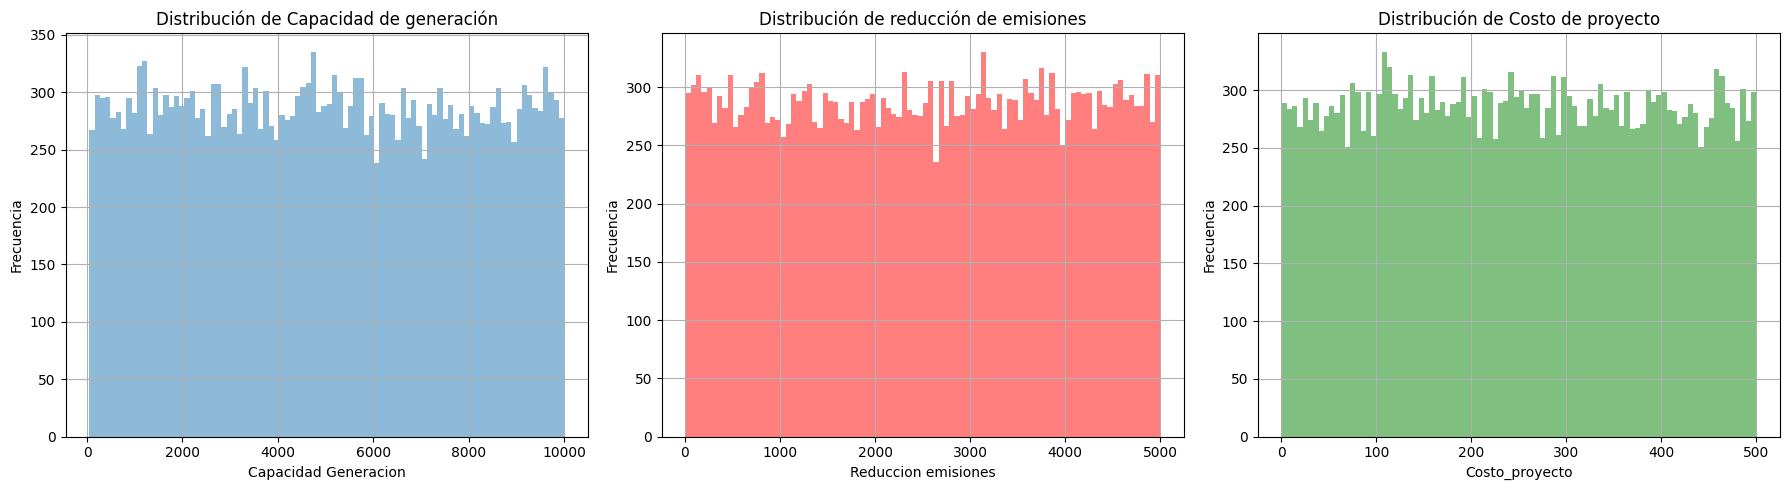

In [91]:
import matplotlib.pyplot as plt

# Convertir los datos de PySpark a Pandas para graficar
df_pandas = df_proyectos.select("capacidad_generacion", "reduccion_emisiones", "costo_proyecto").toPandas()

# Crear subgráficos (1 fila, 3 columnas)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

# Histograma de consumo de energía
axes[0].hist(df_pandas["capacidad_generacion"], bins=90, alpha=0.5)
axes[0].set_xlabel("Capacidad Generacion")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de Capacidad de generación")
axes[0].grid()

# Histograma de emisiones de CO2
axes[1].hist(df_pandas["reduccion_emisiones"], bins=90, alpha=0.5, color='r')
axes[1].set_xlabel("Reduccion emisiones")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución de reducción de emisiones")
axes[1].grid()

# Histograma de la nueva variable
axes[2].hist(df_pandas["costo_proyecto"], bins=90, alpha=0.5, color='g')
axes[2].set_xlabel("Costo_proyecto")
axes[2].set_ylabel("Frecuencia")
axes[2].set_title("Distribución de Costo de proyecto")
axes[2].grid()

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Mostrar gráfico
plt.show()


##### Obervaciones:

- Calculamos los principales estadísticos desctiptivos para la media para las tres variables numericas que tenemos.

- Observamos graficamente que en los 3 casos la distribución de los datos no esta sesgada hacia ningún lado. Se tienen valores en proporciones muy similares a lo largo del rango de cada variable, lo que quiere decir que cada variable numerica en el dataset esta relativamente equilibrada entre magnitudes con valores bajos y altos

In [73]:
# Procedemos a corregir las tildes de la columna tipo de energia

# Aplicar la UDF definida anteriormente a la columna mencionada
df_proyectos_limpio = df_proyectos.withColumn("tipo_energia_2", quitar_tildes_udf(df_proyectos["tipo_energia"])).drop("tipo_energia")

# Renombro la nueva columna que agregue sin tildes con el nombre de columna original.
df_proyectos_limpio = df_proyectos_limpio.withColumnRenamed("tipo_energia_2","tipo_energia")

# Mostrar el resultado limpio
df_proyectos_limpio.show()


+-----------+----------+--------------------+-------------------+--------------+---------------+--------------+
|proyecto_id|empresa_id|capacidad_generacion|reduccion_emisiones|costo_proyecto|estado_proyecto|  tipo_energia|
+-----------+----------+--------------------+-------------------+--------------+---------------+--------------+
| PROJ000000| EMP016520|             9131.06|            2270.88|         26.03|         Activo|         Solar|
| PROJ000001| EMP012923|             2164.32|             4886.1|        364.36|     Finalizado|         Solar|
| PROJ000002| EMP023136|             2374.24|              446.3|        190.17|  En desarrollo|       Biomasa|
| PROJ000003| EMP004436|             4065.11|            4465.83|         126.6|     Finalizado|    Geotermica|
| PROJ000004| EMP021681|             4581.51|            3280.46|        227.13|         Activo|        Eolica|
| PROJ000005| EMP024018|             6000.17|            4752.33|          88.9|         Activo|    Geot

In [76]:
# Compruebo que lo hizo bien

df_proyectos_limpio.printSchema()
print(df_proyectos_limpio.count())

root
 |-- proyecto_id: string (nullable = true)
 |-- empresa_id: string (nullable = true)
 |-- capacidad_generacion: double (nullable = true)
 |-- reduccion_emisiones: double (nullable = true)
 |-- costo_proyecto: double (nullable = true)
 |-- estado_proyecto: string (nullable = true)
 |-- tipo_energia: string (nullable = true)

25808


In [75]:
df_proyectos_limpio.groupBy('tipo_energia').count().show()


+--------------+-----+
|  tipo_energia|count|
+--------------+-----+
|Hidroelectrica| 5169|
|    Geotermica| 5278|
|         Solar| 4988|
|        Eolica| 5186|
|       Biomasa| 5187|
+--------------+-----+



#### Obervaciones:

- Corregí los campos de la variable tipo energia que contenían tíldes para facilitar posibles cruces futuros, agregaciones, etc, y tener homogenización en los nombres.

- Al agrupar por dicho campo evidencio que no existen incoherencias, no hay tipo de energia que salga duplicado por que en un caso tenga tilde y en otro caso no. Es decir la udf se hizo bien.

In [79]:
# Habiendo realizado la limpieza del segundo dataset junto con su EDA, exportamos el data set limpio,
#el cual será la entrada del siguiente proceso para llegar a las tablas de salida deseadas

df_proyectos_limpio.write.parquet("/content/proyectos_limpio.parquet")

_____________
________

## **EDA para csv Regulaciones Ambientales**

____________

In [80]:
# Leemos el data frame regulaciones

df_regulaciones= spark.read.csv("/content/Regulaciones_Ambientales.csv", header=True, inferSchema=True)
df_regulaciones.show()

+-------------+--------+----------------+--------------------+----------------+
|regulacion_id|    pais|limite_emisiones|subsidios_renovables|impuesto_carbono|
+-------------+--------+----------------+--------------------+----------------+
|    REG000000|   India|         3012.63|                   1|           19.54|
|    REG000001|    EEUU|         7325.54|                   1|           42.41|
|    REG000002|Alemania|         9060.84|                   1|            6.15|
|    REG000003|  España|         7075.95|                   1|           44.65|
|    REG000004|Alemania|         1997.42|                   0|            8.75|
|    REG000005|  Canadá|         1863.48|                   0|           22.81|
|    REG000006|  España|         2415.03|                   1|            9.39|
|    REG000007|    EEUU|         12209.9|                   1|           33.85|
|    REG000008| Francia|         8630.52|                   1|           42.94|
|    REG000009| Francia|         3833.05

In [81]:
df_regulaciones.printSchema()
print("Numero de filas: ", df_regulaciones.count())

root
 |-- regulacion_id: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- limite_emisiones: double (nullable = true)
 |-- subsidios_renovables: integer (nullable = true)
 |-- impuesto_carbono: double (nullable = true)

Numero de filas:  29707


#### Observaciones:

- Tenemos 29707 registros en este dataframe

- Observamos que el tipo de las variables estas correctamente asignado, es decir no se tiene un string en alguna de las variables que debe ser numerica, lo cual nos indica que esas columnas estan correctamente compuestas por valores numericos en todas sus filas.

- Vemos que en la columna pais se tienen valores con tildes, lo cual puede representar un posible inconveniente futuro por lo cual deberiamos homogenizar esto.

In [84]:
# Reviso si hay duplicados agrupando por todos los campos y muestro los registros duplicados
df_regulaciones.groupBy('regulacion_id','pais','limite_emisiones','subsidios_renovables','impuesto_carbono').count().filter(F.col('count')>1).show()

+-------------+----+----------------+--------------------+----------------+-----+
|regulacion_id|pais|limite_emisiones|subsidios_renovables|impuesto_carbono|count|
+-------------+----+----------------+--------------------+----------------+-----+
+-------------+----+----------------+--------------------+----------------+-----+



##### Obervaciones:

- Agrupamos por todos los campos y usamos una función de agregación en este caso count, que nos dara la cantidad de veces que un registro se repite en el dataframe. Filtramos los que se repitan mas de una vez y vemos que el DataFrame esta vacío.

- Al no tener registros duplicados, mantenemos todo igual y procedemos a seguir limpiando los datos con posteriores validaciones según corresponda

In [85]:
# verificamos cuantos valores nulos hay en cada columna del Data frame
df_regulaciones.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_regulaciones.columns
]).show()

+-------------+----+----------------+--------------------+----------------+
|regulacion_id|pais|limite_emisiones|subsidios_renovables|impuesto_carbono|
+-------------+----+----------------+--------------------+----------------+
|            0|   0|               0|                   0|               0|
+-------------+----+----------------+--------------------+----------------+



##### Obervaciones:

- Revisamos la cantidad de valores nulos en cada columna. Vemos que las variables no tienen valores nulos en sus filas, por lo que no eliminamos ni tratamos ningun registro

In [88]:
# En este caso calculamos los principales estadisticos descriptivos para las variables numericas.
df_stats_regulaciones= df_regulaciones.describe('limite_emisiones','impuesto_carbono')
df_stats_regulaciones.show()

+-------+------------------+------------------+
|summary|  limite_emisiones|  impuesto_carbono|
+-------+------------------+------------------+
|  count|             29707|             29707|
|   mean| 8005.963699464767|25.677075773386864|
| stddev|4053.9336374052987|14.163531219478534|
|    min|           1000.25|               1.0|
|    max|          14999.98|              50.0|
+-------+------------------+------------------+



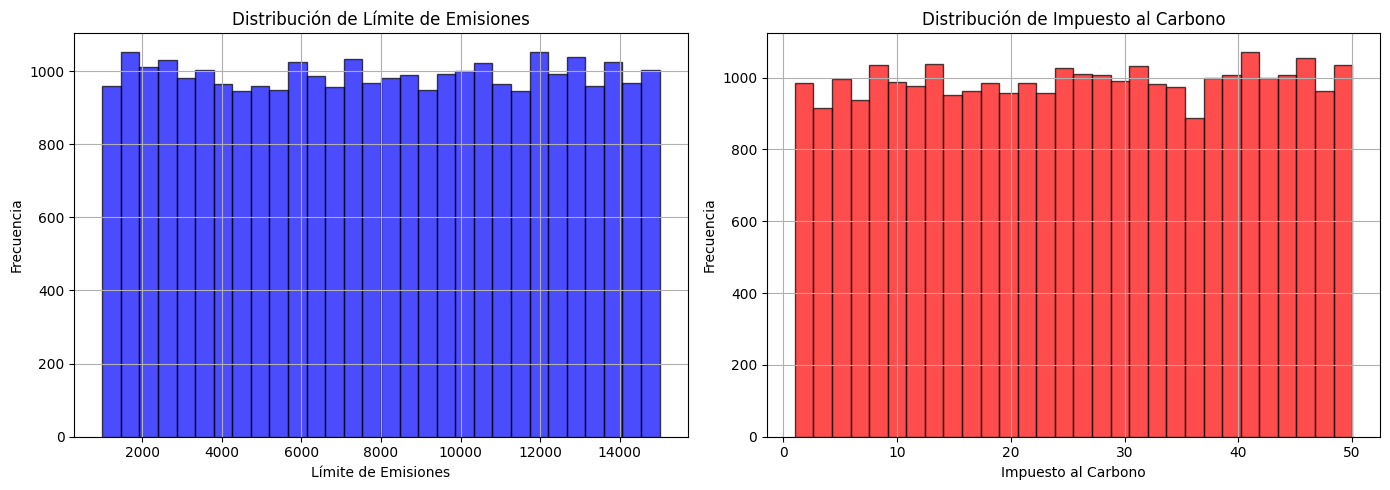

In [87]:
import matplotlib.pyplot as plt

# Convertir el DataFrame de PySpark a Pandas
df_pandas = df_regulaciones.select("limite_emisiones", "impuesto_carbono").toPandas()

# Crear subgráficos: 1 fila, 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 gráficos

# Histograma de limite_emisiones
axes[0].hist(df_pandas["limite_emisiones"], bins=30, alpha=0.7, color="blue", edgecolor="black")
axes[0].set_xlabel("Límite de Emisiones")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de Límite de Emisiones")
axes[0].grid()

# Histograma de impuesto_carbono
axes[1].hist(df_pandas["impuesto_carbono"], bins=30, alpha=0.7, color="red", edgecolor="black")
axes[1].set_xlabel("Impuesto al Carbono")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución de Impuesto al Carbono")
axes[1].grid()

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

# Mostrar la gráfica
plt.show()


##### Obervaciones:

- Calculamos los principales estadísticos desctiptivos para la media para las dos variables numericas que tenemos.

- Observamos graficamente que en los 2 casos la distribución de los datos no esta sesgada hacia ningún lado. Se tienen valores en proporciones muy similares a lo largo del rango de cada variable, lo que quiere decir que cada variable numerica en el dataset esta relativamente equilibrada entre magnitudes con valores bajos y altos

In [92]:
# Procedemos a corregir las tildes de la columna país

# Aplicar la UDF definida anteriormente a la columna mencionada
df_regulaciones_limpio = df_regulaciones.withColumn("pais_2", quitar_tildes_udf(df_regulaciones["pais"])).drop("pais")

# Renombro la nueva columna que agregue sin tildes con el nombre de columna original.
df_regulaciones_limpio = df_regulaciones_limpio.withColumnRenamed("pais_2","pais")

# Mostrar el resultado limpio
df_regulaciones_limpio.show()

+-------------+----------------+--------------------+----------------+--------+
|regulacion_id|limite_emisiones|subsidios_renovables|impuesto_carbono|    pais|
+-------------+----------------+--------------------+----------------+--------+
|    REG000000|         3012.63|                   1|           19.54|   India|
|    REG000001|         7325.54|                   1|           42.41|    EEUU|
|    REG000002|         9060.84|                   1|            6.15|Alemania|
|    REG000003|         7075.95|                   1|           44.65|  Espana|
|    REG000004|         1997.42|                   0|            8.75|Alemania|
|    REG000005|         1863.48|                   0|           22.81|  Canada|
|    REG000006|         2415.03|                   1|            9.39|  Espana|
|    REG000007|         12209.9|                   1|           33.85|    EEUU|
|    REG000008|         8630.52|                   1|           42.94| Francia|
|    REG000009|         3833.05|        

In [93]:
# Compruebo que lo hizo bien

df_regulaciones_limpio.printSchema()
print(df_regulaciones_limpio.count())

root
 |-- regulacion_id: string (nullable = true)
 |-- limite_emisiones: double (nullable = true)
 |-- subsidios_renovables: integer (nullable = true)
 |-- impuesto_carbono: double (nullable = true)
 |-- pais: string (nullable = true)

29707


In [94]:
df_regulaciones_limpio.groupBy('pais').count().show()


+--------+-----+
|    pais|count|
+--------+-----+
| Francia| 3005|
|   India| 2896|
|   China| 2998|
|Alemania| 3038|
|  Mexico| 2923|
|  Espana| 2942|
|   Japon| 3065|
|    EEUU| 2973|
|  Canada| 2936|
|  Brasil| 2931|
+--------+-----+



#### Obervaciones:

- Corregí los campos de la variable pais que contenían tíldes para facilitar posibles cruces futuros, agregaciones, etc, y tener homogenización en los nombres.

- Al agrupar por dicho campo evidencio que no existen incoherencias, no hay un pais que salga duplicado por que en un caso tenga tilde y en otro caso no. Es decir la udf se hizo bien.

In [95]:
# Habiendo realizado la limpieza del segundo dataset junto con su EDA, exportamos el data set limpio,
#el cual será la entrada del siguiente proceso para llegar a las tablas de salida deseadas

df_regulaciones_limpio.write.parquet("/content/regulaciones_limpio.parquet")